<a href="https://colab.research.google.com/github/ChrisKantor/Deep-Learning/blob/main/Homework%203/Deep_Learning_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Deep Learning Assignment Notes:
#Need to submite 3 things, training code, the trained model, and then a bunch of results.
#need to try all of the things listed in q2
#lots of tial and eror with the hyperparameter tuning

#data set is about baby vitals for detecting baby pain
#3 classes: no pain, mild pain, lots of pain
#col 1 is heart rate
#col 2 is respiratory rate
#col 3 is oxygen saturation
#Can merge all the csv files into 1 large one
#randomize and then split into training/validation data

#need to clean the data, invalid data could be in any column

#need 5 HIDDEN layers, so 7 total with the input and output layers
#We can choose any number of neurons per layer

#70% accuracy is a good minimum

#Submit the best model only, but save figures for the other models with hyperparameter tuning
#the model is not enough, need to submit a script which loads the model and then runs the test dataset on it
#the test data has 2 folders same format as training data, need to combine the data into 1 csv

#the testing script can be on a seperate cell in the notebook

#figures are for validation loss
#don't need to combine hyperparameters, just do them without each other, should be 12 figures total for part 2
#1 figure for part 1 (the best model)

# **Loading Dataset**

In [47]:
#import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import os
from matplotlib import pyplot as plt

## Mount Google drive
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/Homework 3 Data/'

mainFile = "baby_data.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
#create a new csv file that will hold all of our valid data
with open("/content/drive/MyDrive/Colab Notebooks/Deep Learning/Homework 3 Data/" + mainFile, 'w') as csvfile:
  csvwriter = csv.writer(csvfile)

  # writing the column names
  csvwriter.writerow(['Heart Rate', 'Respiratory Rate', 'O2 Level', 'Label'])

  #use the os library to iterate through all files in the current path
  for (root,dirs,files) in os.walk(data_dir, topdown=True):
    #open each CSV file, we don't want to open any other type of file
    for f in files:
      if f.endswith(".csv"):
        #in each file, go through each row and check if it is valid
        with open(os.path.join(root, f), mode ='r') as csvFile:
          csvData = csv.reader(csvFile)

          #one way to tell if the data is invalid is if the label is NOT [0, 1, 2]. This means there was something wrong with one of the sensors at the time of capture
          #another way is to check if the heart rate, respiratory rate, or o2 level is too low, in this case we check if it is <= 0. if so, there was something wrong with the sensor
          for row in csvData:
            try:
              if row[4] in "012" and int(row[1]) > 0 and int(row[2]) > 0 and int(row[3]) > 0:   #data is valid, so add it to the main csv

                #row[0] just stores the row # in the csv file, so it is not needed in the training dataset
                csvwriter.writerow([row[1], row[2], row[3], row[4]])

            #Catches errors that occur when an element cannot be parsed into an integer. In this case the row is invalid so we can skip it
            except ValueError:
              continue

print("Done writing to main csv file: ", mainFile)

Done writing to main csv file:  baby_data.csv


In [49]:
#Now we have a csv file that has ALL of the valid data which we will use in training our model
#The next step is to split the data into a training and validation set, using a 90/10 split
dataframe = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Deep Learning/Homework 3 Data/" + mainFile, sep=',')
print(dataframe.shape)
print(dataframe.head())


#split the data into a training and validation set using a 90/10 split, and randomize beforehand
trainData, valData = np.split(dataframe.sample(frac=1), [int(0.9*len(dataframe))])

#save the labels to a seperate dataframe and remove them from the data dataframe
trainLabel = trainData.pop('Label')
valLabel = valData.pop('Label')

(16655, 4)
   Heart Rate  Respiratory Rate  O2 Level  Label
0         165                48        98      0
1         165                48        97      0
2         166                48        97      0
3         166                46        97      0
4         166                49        97      0


In [50]:
#Hyperparameter Tuning
batchSize = 32
learningRate = 0.0001
numEpochs = 50
normalize = False
optType = 'Adam'
momentum = 0.9
initType = 'Random'
regularize = False         #using L2 regularization in tensorflow
regularizeLamda = 0.0001



#Choosing optimizer
if optType == 'Adam':
  opt = tf.keras.optimizers.Adam(learning_rate = learningRate)

elif optType == 'SGD':
  opt = tf.keras.optimizers.SGD(learning_rate = learningRate, momentum = momentum)


#Normalizing data
if normalize:
  #normalize the data using pandas - use standard scaling
  #normalize the validation data using the training datas values(?)
  for col in trainData.columns:
    trainData[col] = trainData[col]  / trainData[col].abs().max()

  for col in valData.columns:
    valData[col] = valData[col]  / valData[col].abs().max()

# Model Creation and Training

In [51]:
# #Create the model
# if regularize:
#   model = tf.keras.models.Sequential([
#     tf.keras.layers.Input(3),
#     tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(regularizeLamda)),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(128, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(regularizeLamda)),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(regularizeLamda)),
#     tf.keras.layers.Dense(3)
#   ])

# else:
#   model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(3),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(3)
#   ])

# #creating the loss function we will use
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# model.compile(optimizer=opt,
#               loss=loss_fn,
#               metrics=['accuracy'])


#or optionally load a model from a file
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Deep Learning/Homework 3 Data/bestModel.keras")

In [52]:
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/Homework 3 Data/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


#Running the model
print("Running Model\n")
history = model.fit(trainData, trainLabel, epochs=numEpochs, batch_size=batchSize, validation_data=(valData, valLabel), callbacks=[model_checkpoint_callback])


#load the best model using the callback
model.load_weights(checkpoint_filepath)

print("\n\nEvaluating Best Model\n")
#evaluation the model on the validation data
model.evaluate(valData, valLabel, verbose=2)

Running Model

Epoch 1/50
469/469 [==============================] - 3s 5ms/step - loss: 0.6533 - accuracy: 0.7024 - val_loss: 0.6325 - val_accuracy: 0.7149
Epoch 2/50
469/469 [==============================] - 2s 4ms/step - loss: 0.6550 - accuracy: 0.7013 - val_loss: 0.6278 - val_accuracy: 0.7143
Epoch 3/50
469/469 [==============================] - 1s 3ms/step - loss: 0.6508 - accuracy: 0.7044 - val_loss: 0.6298 - val_accuracy: 0.7173
Epoch 4/50
469/469 [==============================] - 1s 3ms/step - loss: 0.6487 - accuracy: 0.7063 - val_loss: 0.6298 - val_accuracy: 0.7161
Epoch 5/50
469/469 [==============================] - 1s 3ms/step - loss: 0.6494 - accuracy: 0.7052 - val_loss: 0.6256 - val_accuracy: 0.7203
Epoch 6/50
469/469 [==============================] - 1s 3ms/step - loss: 0.6493 - accuracy: 0.7042 - val_loss: 0.6300 - val_accuracy: 0.7161
Epoch 7/50
469/469 [==============================] - 1s 3ms/step - loss: 0.6489 - accuracy: 0.7022 - val_loss: 0.6346 - val_accuracy

[0.6120794415473938, 0.7280912399291992]

In [55]:
#save the model
model.save("/content/drive/MyDrive/Colab Notebooks/Deep Learning/Homework 3 Data/bestModel.keras")
print("Saved Model")

Saved Model


# Graph Results

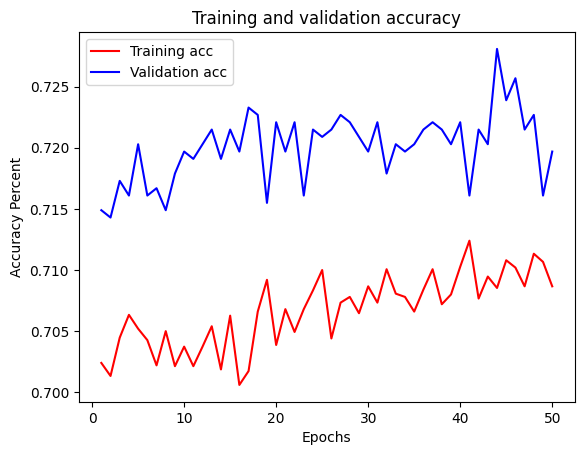

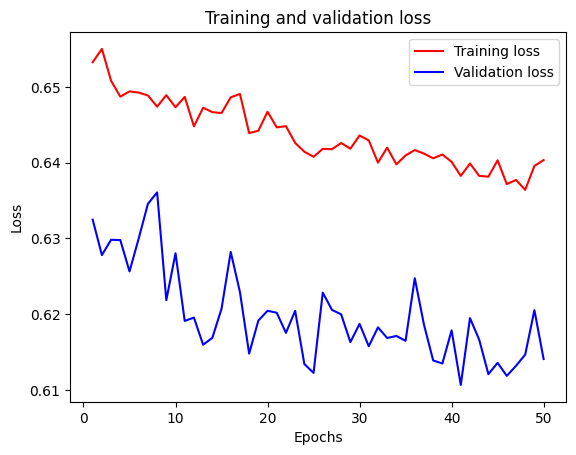

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy Percent")
plt.legend()

# #Saving the Accuracy Figure
# plt.savefig("/content/drive/MyDrive/Colab Notebooks/Deep Learning/Homework 3 Data/best_model_Accuracy.png")
# plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()


# #Saving the Loss Figure
# plt.savefig("/content/drive/MyDrive/Colab Notebooks/Deep Learning/Homework 3 Data/best_model_Loss.png")
# plt.show()

# Running Test Set for Project Grading

In [57]:
#import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import os
from matplotlib import pyplot as plt

## Mount Google drive and load test data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/Homework 3 Data/'

mainFile = "test.csv"

#read test.csv, dropping the first column as it just holds the index of the rows, which we don't need
testData = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Deep Learning/Homework 3 Data/" + mainFile, sep=',', usecols=[1, 2, 3, 4], names = ['Heart Rate', 'Respiratory Rate', 'O2 Level', 'Label'])
testLabel = testData.pop("Label")


#load the model from a saved file
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Deep Learning/Homework 3 Data/bestModel.keras")

#evaluation the model on the test data
loss, acc = model.evaluate(testData, testLabel, verbose=2)
print("Loss on test data: ", loss)
print("Accuracy on test data: ", acc)

Mounted at /content/drive
4/4 - 0s - loss: 0.5214 - accuracy: 0.8065 - 30ms/epoch - 8ms/step
Loss on test data:  0.5213620662689209
Accuracy on test data:  0.8064516186714172
